## Tutorial: Gene annotation comparison

In this example, we compare two human gene annotation sets, namely gencode (v39) and chess (v3.0.1).
We load all protein_coding genes from both annotation sets, update the gene-names to their latest given symbol (using gennames.org data) and compare both lists. We then exemplary show how to further analyze differences between those gene annotation sets.

*Required resources:*
- Human genome FASTA (GRCh38), accessible at https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000001405.26/
- Full gencode annotation gff3 file (sorted), available at https://www.gencodegenes.org/human/
- Full chess 3.0.1 annotation gff3 file (sorted), available at https://github.com/chess-genome/chess/releases/download/v.3.0.1/chess3.0.1.gff.gz

In [1]:
import os, pathlib, platform
from tqdm.auto import tqdm
import tempfile
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import traceback
import math

# load rnalib
import rnalib as rna
from rnalib import gi, SEP, display_textarea

display(f"Running rnalib {rna.__version__} on python {platform.python_version()}")

'Running rnalib 1.0.0 on python 3.10.4'

## Test datasets

This notebook as well as rnalib's testing suite use various test resources (genomics data files and indexing structures) that can be created by 
running the rnalib `rnalib_create_testdata` script or by calling the `testdata.create_testdata()` method. There are two seperate resource sets:

* test_resources: small test datasets that are used by rnalib's test suite
* large_test_resources: larger test files that are needed to demonstrate rnalib under realistic conditions. 

Rnalib knows about the test data directory via the package-global __RNALIB_TESTDATA__ variable. This variable can either be set via the "RNALIB_TESTDATA" environment variable or by monkeypatching (rna.__RNALIB_TESTDATA__ = <mydir>) as shown below. Once this is done, test data resources can be accessed via 
`get_resource(<resource_id>)`. Rnalib will recreate these resources only if they are not found in the provided output folder.


In [2]:
rna.__RNALIB_TESTDATA__ = "rnalib_testdata/"

if not os.path.isdir(rna.__RNALIB_TESTDATA__):
    os.mkdir(rna.__RNALIB_TESTDATA__)

rna.testdata.create_testdata(rna.__RNALIB_TESTDATA__, 
                             rna.testdata.large_test_resources)

display(f"Testdata at {rna.__RNALIB_TESTDATA__}")
display_textarea('\n'.join(rna.dir_tree(pathlib.Path(rna.__RNALIB_TESTDATA__))))

============= Output directory: rnalib_testdata/=========


Creating testdata:   0%|          | 0/5 [00:00<?, ?it/s]

Creating testdataset full_gencode_gff
Resource already exists, skipping...
Creating testdataset full_chess_gtf
Resource already exists, skipping...
Creating testdataset gene_aliases
Resource already exists, skipping...
Creating testdataset grch38_chr20
Resource already exists, skipping...
Creating testdataset grch38_umap
Resource already exists, skipping...
========= All done with 0 errors  ==========


'Testdata at rnalib_testdata/'

Now we load gencode and chess annotation data and build the respective transcriptomes (takes about 4min).
We configure a transcript filter that includes only entries with gene_type 'protein_coding' and restrict this analysis to all canonical GRCh38 chromsomes (i.e., chr1-22,X,Y,M).
To update to the latest gene symbols, we use genenames.org data and configure via the 'gene_name_alias_file' property. rnalib automatically updates gene names accordingly. 

In [7]:
alias_txt=rna.get_resource("gene_aliases") # gene name aliases
gencode_gff=rna.get_resource("full_gencode_gff") # Gencode data
chess_gff=rna.get_resource("full_chess_gtf") # Chess data

txfilter = rna.TranscriptFilter(). \
    include_gene_types({'protein_coding'}). \
    include_chromosomes(rna.CANONICAL_CHROMOSOMES['GRCh38'])

t_gc=rna.Transcriptome(
    annotation_gff = gencode_gff,
    annotation_flavour ='gencode',
    copied_fields =['gene_type', 'transcript_type'],
    gene_name_alias_file = alias_txt,
    feature_filter = txfilter)

# NOTE: in chess, there ais no 'transcript_type' annotation
t_ch=rna.Transcriptome(
    annotation_gff = chess_gff,
    annotation_flavour ='chess',
    copied_fields =['gene_type'],
    gene_name_alias_file = alias_txt,
    feature_filter = txfilter)

# compare
display(SEP)
display(t_gc)
display(t_ch)

load gene aliases:   0%|          | 0/43840 [00:00<?, ?it/s]

Building transcriptome (25 chromosomes)
:   0%|          | 0/25 [00:00<?, ?it/s]

Build interval trees:   0%|          | 0/19982 [00:00<?, ?it/s]

load gene aliases:   0%|          | 0/43840 [00:00<?, ?it/s]

Building transcriptome (25 chromosomes)
:   0%|          | 0/25 [00:00<?, ?it/s]

Build interval trees:   0%|          | 0/19810 [00:00<?, ?it/s]

---

Transcriptome with 19982 genes and 164578 tx

Transcriptome with 19810 genes and 99150 tx

Please note that, the numbers reported in the [Chess3 paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-023-03088-4/) differ, particularly in the number of protein_coding gencode transcripts:

| Database    | Number of protein-coding gene loci | Number of protein-coding transcripts | Number of distinct protein sequences | Number of gene loci (all types) |
|-------------|------------------------------------|--------------------------------------|--------------------------------------|---------------------------------|
| CHESS v3    | 19,839                             | 99,202                               | 73,767                               | 41,356                          |
| RefSeq v110 | 19,884                             | 129,740                              | 88,662                               | 43,380                          |
| GENCODE v41 | 19,419                             | 110,309                              | 92,968                               | 46,181                          |

*Table 1 from the [CHESS3 paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-023-03088-4/tables/1): Total number of genes and protein-coding isoforms in current versions of CHESS, RefSeq, and GENCODE. Genes are counted on the primary chromosomes and unplaced scaffolds from the human reference genome GRCh38, excluding the alternative scaffolds. Pseudogenes, VDJ segments, and C regions are not included in the totals shown in the final column.*

This can partially be explained by the different chromosome sets used (we include only primary chromosomes).

Now we can have a look at the shared and unique (normalized) gene names and
display the unique gene names for genocde and chess.

In [8]:
# cmp_sets is a rnalib utility function for set comparison
shared, uniq_gc, uniq_ch = rna.cmp_sets({x.gene_name for x in t_gc.genes}, 
                                       {x.gene_name for x in t_ch.genes}) 
display(f"Unique gene names in gencode: {len(shared)+len(uniq_gc)}, in chess: {len(shared)+len(uniq_ch)}")
display(f"Shared: {len(shared)}, only in gencode: {len(uniq_gc)}, only in chess: {len(uniq_ch)}")
display_textarea(f"Unique in gencode: {uniq_gc}")
display_textarea(f"Unique in chess: {uniq_ch}")

'Unique gene names in gencode: 19955, in chess: 19787'

'Shared: 19251, only in gencode: 704, only in chess: 536'

As expected, most genes are annotated in both sets as expected but there are some unique entries too.
Most unique genecode genes have no given name but an ensembl gene id (starting with ENSG), 
while most unique chess genes start with “LOC” which indicates unknown function.
Let's have a look at 'GCNT7' which is only annotated in gencode 
(https://www.genecards.org/cgi-bin/carddisp.pl?gene=GCNT7)
 We query the chess annotation set for the coordinates of the GCNT7 gene in the gencode annotation:

In [9]:
display(f"In Gencode, GCNT7 is annotated at {t_gc.gene['GCNT7'].location}")
display("In Gencode at this region:", [(x.location, x.gene_name, x.strand) for x in t_gc.query(t_gc.gene['GCNT7'], feature_types=['gene'])])
display("In Chess at this region:", [(x.location, x.gene_name, x.strand) for x in t_ch.query(t_gc.gene['GCNT7'], feature_types=['gene'])])

'In Gencode, GCNT7 is annotated at chr20:56491492-56525925 (-)'

'In Gencode at this region:'

[(chr20:56468585-56519449 (+), 'RTF2', '+'),
 (chr20:56491492-56525925 (-), 'GCNT7', '-'),
 (chr20:56517187-56526152 (+), 'FAM209A', '+')]

'In Chess at this region:'

[(chr20:56468627-56519449 (+), 'RTF2', '+'),
 (chr20:56524744-56526152 (+), 'FAM209A', '+')]

Indeed, it shows only RTF2 and 'FAM209A', both on the opposite strand.
Vice versa, we look at 'MMP24-AS1-EDEM2' which is found only in the chess annotation

In [10]:
display(f"In Chess, MMP24-AS1-EDEM2 is annotated at {t_ch.gene['MMP24-AS1-EDEM2'].location}")
display("In Gencode at this region:", [(x.location, x.gene_name, x.strand) for x in t_gc.query(t_ch.gene['MMP24-AS1-EDEM2'], feature_types=['gene'])])
display("In Chess at this region:", [(x.location, x.gene_name, x.strand) for x in t_ch.query(t_ch.gene['MMP24-AS1-EDEM2'], feature_types=['gene'])])

'In Chess, MMP24-AS1-EDEM2 is annotated at chr20:35115364-35278122 (-)'

'In Gencode at this region:'

[(chr20:35115364-35147336 (-), 'EDEM2', '-'),
 (chr20:35172072-35216240 (+), 'PROCR', '+'),
 (chr20:35201745-35278131 (-), 'MMP24OS', '-'),
 (chr20:35226690-35276998 (+), 'MMP24', '+'),
 (chr20:35267885-35280043 (-), 'ENSG00000261582', '-')]

'In Chess at this region:'

[(chr20:35115364-35147336 (-), 'EDEM2', '-'),
 (chr20:35115364-35278122 (-), 'MMP24-AS1-EDEM2', '-'),
 (chr20:35171096-35216240 (+), 'PROCR', '+'),
 (chr20:35226690-35276998 (+), 'MMP24', '+'),
 (chr20:35276352-35278122 (-), 'MMP24OS', '-')]

Note that not all gene names in a transcriptome are unique. For example, genes in pseudo-autosomal 
regions (PAR), such as WASH6P, are annotated at different genomic locations (e.g., X and Y chromosomes)
with the same gene_name but different feature IDs. rnalib properly handles such
genes and maintains a dict that maps duplicate gene_names to the respective gene objects:

In [11]:
display_textarea(f"Duplicate gene names in gencode: {t_gc.duplicate_gene_names}") 
display_textarea(f"Duplicate gene names in chess: {t_ch.duplicate_gene_names}")

For a more detailed analysis, we iterate all gencode genes and overlap with chess annotations 
using rnalib's annotation iterator. 
We count some stats and select the chess annotation with the highest overlap for a gene-to-gene comparison.
Finally, we calculate a histogram of absolute difference between gencode and chess annotations for start and end 
coordinates and plot the first 50 values in a barplot

  0%|          | 0/25 [00:00<?, ?it/s]

Counter({'gencode_genes': 19982,
         'differing_location': 11726,
         'differing_gene_name': 664,
         'differing_gene_name_uniq': 663,
         'gencode_genes_no_match': 42})

{'differing_location_example': 'gc: chrY:57184216-57197337 (+), ch: {gene@chrY:57184129-57197869}',
 'differing_gene_name_example': "gc: ENSG00000288258, ch: ['CMC4', 'MTCP1']"}

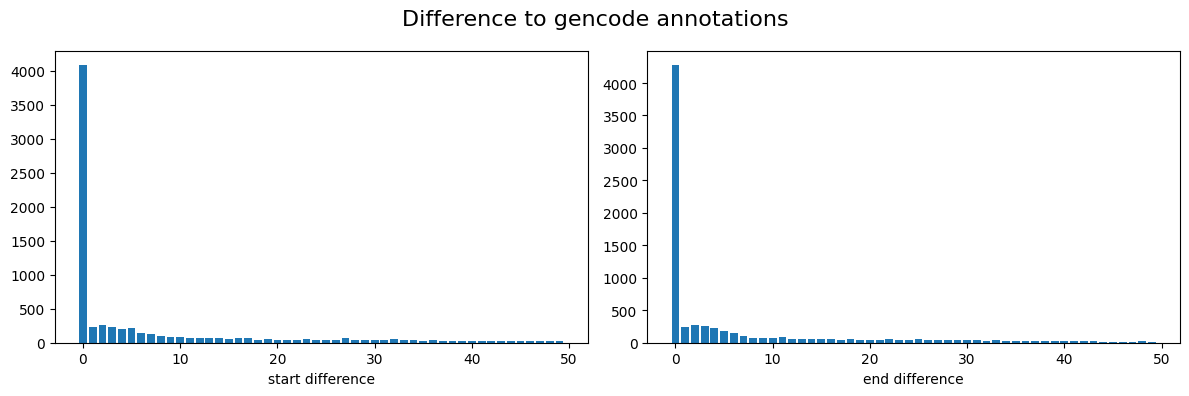

In [12]:
stats=Counter()
examples=dict()
hist_start, hist_end=Counter(), Counter()
diff_annos=list()
with rna.AnnotationIterator(
    rna.TranscriptomeIterator(t_gc, feature_types='gene'),
    rna.TranscriptomeIterator(t_ch, feature_types='gene')) as it:
    for gene_gc, dat in it:
        stats['gencode_genes']+=1
        if len(dat.it0)==0:
            stats['gencode_genes_no_match']+=1
            continue
        genes_ch = {g.location for g in dat.it0}
        # check whether gene names match
        if gene_gc.gene_name not in [g.gene_name for g in genes_ch]:
            stats['differing_gene_name'] += 1
            if gene_gc.gene_name not in shared:
                stats['differing_gene_name_uniq'] += 1
            examples['differing_gene_name_example'] = f"gc: {gene_gc.gene_name}, ch: {[g.gene_name for g in genes_ch]}"
            continue
        # check whether coordinates match
        if gene_gc.get_location() not in [g.get_location() for g in genes_ch]:
            stats['differing_location'] += 1
            examples['differing_location_example'] = f"gc: {gene_gc.get_location()}, ch: {genes_ch}"
            # select overlapping chess annotation with minimum abs difference
            overlaps={g:abs(gene_gc.left_pos().distance(g.left_pos()))+abs(gene_gc.right_pos().distance(g.right_pos())) for g in genes_ch}
            closest_anno=min(overlaps, key=overlaps.get)
            abs_diff_start = abs(gene_gc.left_pos().distance(closest_anno.left_pos()))
            abs_diff_end = abs(gene_gc.right_pos().distance(closest_anno.right_pos()))
            hist_start[abs_diff_start]+=1
            hist_end[abs_diff_end]+=1
            diff_annos.append((abs_diff_start+abs_diff_end,gene_gc, closest_anno))
display(stats)
display(examples)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
x,y=zip(*sorted(hist_start.items())[:50])
ax1.bar(x,y)
ax1.set_xlabel('start difference')
x,y=zip(*sorted(hist_end.items())[:50])
ax2.bar(x,y)
ax2.set_xlabel('end difference')
fig.suptitle(t='Difference to gencode annotations', fontsize=16)
fig.tight_layout()

So most annotations indeed differ between gencode and chess and the differing ones share 
either the same start or the same end coordinates. 
There are, however, some annotations with very large differences (multiple Mbases) that are not shown in the barplots. Let's have a closer look at the 10 most extreme examples:

In [13]:
for diff, g_gc, g_ch in sorted(diff_annos, reverse=True)[:10]:
    display(f"{diff}, {len(g_gc)}, {g_gc.gene_name}, {g_gc.get_location()}, {g_ch.gene_name}, {g_ch.get_location()}")

'955365, 1216867, RUNX1, chr21:34787801-36004667 (-), RUNX1, chr21:34787801-35049302 (-)'

'779222, 2473539, RBFOX1, chr16:5239802-7713340 (+), RBFOX1, chr16:6019024-7713340 (+)'

'727705, 1213807, ZFPM2, chr8:104590733-105804539 (+), ZFPM2, chr8:105318438-105804539 (+)'

'706284, 1435601, RBMS3, chr3:28574791-30010391 (+), RBMS3, chr3:29281071-30010395 (+)'

'702186, 1287656, TBC1D5, chr3:17157162-18444817 (-), TBC1D5, chr3:17157162-17742631 (-)'

'693913, 1337027, LSAMP, chr3:115802363-117139389 (-), LSAMP, chr3:115802374-116445487 (-)'

'622111, 961104, ZNF385D, chr3:21412218-22373321 (-), ZNF385D, chr3:21412218-21751210 (-)'

'605796, 149049, PPARGC1A, chr4:23755041-23904089 (-), PPARGC1A, chr4:23792021-24472905 (-)'

'603553, 766460, SUMF1, chr3:3700814-4467273 (-), SUMF1, chr3:4304363-4467269 (-)'

'566618, 57500, SCHIP1, chr3:159839861-159897360 (+), SCHIP1, chr3:159273244-159897359 (+)'

Finally, lets have a look at the number of annotated transcripts per annotation set.
For this analysis, we consider only the shared genes

'R_pearson=0.4618310320651033'

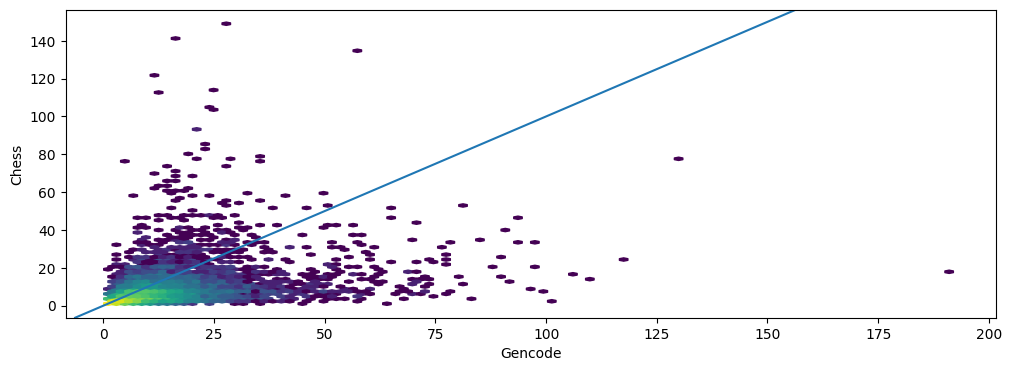

In [14]:
# calculate vectors of pairwise transcript counts for all shared gene_names
x, y = zip(*[(len(t_gc.gene[gn].transcript), len(t_ch.gene[gn].transcript) ) for gn in shared ])
# scatter plot
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.hexbin(x,y, bins='log')
ax.axline((1, 1), slope=1)
plt.xlabel('Gencode')
plt.ylabel('Chess')
# correlation coefficient
display(f'R_pearson={np.corrcoef(x,y)[0,1]}')

We can observe large differences between the compared annotation set. Let's
look at the most extreme example.

In [15]:
max_diff_idx = np.argmax(np.array([abs(a-b) for a,b in zip(x,y)]))
max_diff_gene = list(shared)[max_diff_idx]
display(f"The gene with the largest difference in annotated transcripts is {t_gc.gene[max_diff_gene].gene_name}")

tr_gc, tr_ch = t_gc.gene[max_diff_gene].transcript, t_ch.gene[max_diff_gene].transcript
display(f"In gencode, there are {len(tr_gc)} tx, in chess, there are {len(tr_ch)}")
display_textarea(f"gencode tx: {tr_gc}")
display_textarea(f"chess tx: {tr_ch}")

'The gene with the largest difference in annotated transcripts is MAPK10'

'In gencode, there are 192 tx, in chess, there are 18'

In a final analysis, we want to count the number of introns with canonical splice sites, i.e.,
having GT and AG at either end of that intron. For this, we must load gene sequences and in this
example we do this only for chr20. 

First, we instantiate 2 new transcriptomes that use the same configuration as before but now add the grch38_chr20 
reference sequence and load those sequences at startup. Note that rnalib detects that the referenced genome contains
only chr20 and will merge the respective refdicts resulting in only genes/transcripts located on chr20 being loaded.

In [21]:
t_gc_chr20=rna.Transcriptome(
    annotation_gff = gencode_gff,
    annotation_flavour ='gencode',
    genome_fa = rna.get_resource("grch38_chr20"), # GRCh38 chr20 reference sequence
    load_sequence_data=True,
    copied_fields =['gene_type', 'transcript_type'],
    gene_name_alias_file = alias_txt,
    feature_filter = txfilter)

t_ch_chr20=rna.Transcriptome(
    annotation_gff = chess_gff,
    annotation_flavour ='chess',
    genome_fa = rna.get_resource("grch38_chr20"), # GRCh38 chr20 reference sequence
    load_sequence_data=True,
    copied_fields =['gene_type'],
    gene_name_alias_file = alias_txt,
    feature_filter = txfilter)

# show merged refdicts and numbers of loaded genes/transcripts
display(SEP)
display(t_gc_chr20, t_gc_chr20.merged_refdict)
display(t_ch_chr20, t_ch_chr20.merged_refdict)

load gene aliases:   0%|          | 0/43840 [00:00<?, ?it/s]

Building transcriptome (1 chromosomes)
:   0%|          | 0/1 [00:00<?, ?it/s]

Load sequences:   0%|          | 0/546 [00:00<?, ?it/s]

Build interval trees:   0%|          | 0/546 [00:00<?, ?it/s]

load gene aliases:   0%|          | 0/43840 [00:00<?, ?it/s]

Building transcriptome (1 chromosomes)
:   0%|          | 0/1 [00:00<?, ?it/s]

Load sequences:   0%|          | 0/535 [00:00<?, ?it/s]

Build interval trees:   0%|          | 0/535 [00:00<?, ?it/s]

---

Transcriptome with 546 genes and 3629 tx (+seq)

RefSet (size: 1): dict_keys(['chr20']), dict_values([64444167]) name: References from FASTA file b'rnalib_testdata//bigfiles/grch38_chr20.fa.gz',References from TABIX file b'rnalib_testdata//bigfiles/gencode_39.gff3.gz' 

Transcriptome with 535 genes and 2464 tx (+seq)

RefSet (size: 1): dict_keys(['chr20']), dict_values([64444167]) name: References from FASTA file b'rnalib_testdata//bigfiles/grch38_chr20.fa.gz',References from TABIX file b'rnalib_testdata//bigfiles/chess3.0.1.gtf.gz' 

,annotation,SJ,count
0,gencode,GT/AG,25395
17,chess,GT/AG,22990
1,gencode,GC/AG,216
18,chess,GC/AG,178
5,gencode,AT/AC,31


'In gencode, we found 98.86708712917542% canonical splice sites'

'In chess,   we found 99.01373874843877% canonical splice sites'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


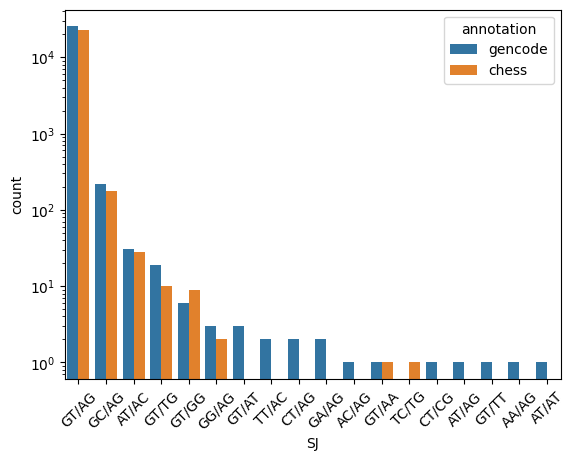

In [24]:
# now, lets count introns with and without consensus dinucleotides (GT and AG) 
# at either end of that intron
stats = defaultdict(Counter)
for name, tr in [('gencode',t_gc_chr20),('chess', t_ch_chr20)]:
    for intron, _ in rna.TranscriptomeIterator(tr, feature_types='intron'):
        if len(intron)<4:
            continue
        a,b = intron.sequence[:2].upper(), intron.sequence[-2:].upper()
        if intron.strand=='-': # reverse complement for minus strand genes
            a,b = rna.reverse_complement(b), rna.reverse_complement(a)
        stats[name][f'{a}/{b}'] += 1
# convert to dataframe
df = pd.DataFrame.from_records([(n,t,c) for n in stats for t,c in stats[n].items()], 
                               columns=['annotation', 'SJ', 'count']).sort_values(['count'], ascending=False)
display(df.head())

# Show % canonical SJ
# compare: PMID: 11058137: 98.71% canonical, 0.56% non-canonical GC-AG
display(f"In gencode, we found {stats['gencode']['GT/AG'] / stats['gencode'].total() * 100}% canonical splice sites")
display(f"In chess,   we found {stats['chess']['GT/AG'] / stats['chess'].total() * 100}% canonical splice sites")

# plot results
sns.barplot(x='SJ', y='count', data=df, hue='annotation')
_= plt.xticks(rotation=45)
_= plt.yscale("log")


So, gencode shows more non-canonical splice junctions that are possibly wrong.